# Credit card fraud transactions detection & classifiers comparison 

## Case study

A client (bank) wants to catch suspicious credit card transactions for further fraud investigation. The bank decided to invest in a new system to build a prediction model that is capable of detecting potential fraudulent transactions. The bank provided us with their historical transactions data. Each record constitutes a set of attributes for each transaction with a flag of either being normal or fraudulent. Fraudulent cases constitute a small percentage of the overall transactions.

The data can be found in the _data_ folder in this repository.

Each case that is nominated by the predictive model to be fraudulent and turns out to be not fraudulent costs the bank around £1k. Such cases harm the bank’s customer satisfaction ratings. The bank is willing to allow an annual budget for these cases of £30k. 

Each case that is not nominated by the predictive model to be fraudulent and turns out to be fraudulent costs the bank £10k on average. Such cases harm the bank’s reputation and costs them future customers. The bank is willing to allow an annual budget for these cases of £50k.

The additional bank requirements are: 

1. to catch at least 90% of actual fraudulent cases 
2. to ensure that at least 70% of the predicted cases for further investigation are actually fraudulent.

<br><br>

## Aims, objectives and plan



The **ultimate goal** of the project is to detect anomalies in financial transactions; specifically credit card transactions.
The secondary goals but still important are: 
* Complete the project within the allocated budget which is £1 million. 
* Capture >90% of the fraudulent cases from the actual cases that are fraudulent transactions.
* The model's performance in predicting fraudulent cases is to give a 70% probability of the predicted cases to be actually fraudulent. This translates to a Precission score of >70%.


The **main objective** that will help to achieve this is to build the machine learning model to detect these anomalies/ potential fraudulent transactions.

Other objectives that will help to succeed in the goal of the project are:  
* Minimise the transactions that are detected as fraudulent but in reality are not - minimise false positive cases.
* Minimise the transactions that are detected as not fraudulent but in reality they are - minimise false negative cases.
* Constraint the maximum count of false negatives to 5.
* Constraint the maximum count of false positives to 30.

##  Case study analysis
State the key points that you found in the case and how you intend to deal with them appropriately to address the bank's needs. (You can include more than four points.)


1. Complete the project within the allocated budget which is £1 million. This will potentially include costs of labour, meeting costs, information sourcing and administration costs.

2. Capture >90% of the fraudulent cases - this means the model Recall metric to be >90% since the number of FN will indicate the fraudulent transactions that have 'escaped'.

3. The model's performance in predicting fraudulent cases is to give a 70% probability of the predicted cases to be actually fraudulent. This translates to a Precision score of >70%.

4. Minimise the transactions that are detected as fraudulent but in reality are not - minimise false positive cases.Especially to meet the allocated budget of the bank for up to 30 false positives and not exceeding these.

5. Minimise the transactions that are detected as not fraudulent but in reality they are - minimise false negative cases.Especially to meet the allocated budget of the bank for up to 5 false negatives and not exceeding these.

6. To achieve the above goals, the data I intend to develop two classification machine learning algorithms to compare their performances and evaluate them using classification technique metrics. I have selected to develop two famous classification models, KNN and RandomForest and I explain the reasons for my selctions in the following sections. Through my comparison I will be able to make conclussions as to the most suitable model for this application but also what is the model to provide the most cost-effective solution for the business. 

7. I will also perform hyperparameter tuning using the grid search method to be able to establish which model parameters will give the best results concerning the project objectives above.



## Imports
First I will import the packages needed for the project. Then I will import the raw data in the pandas dataframe to be able to manipulate the data.

In [620]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
np.random.seed(42)


In [621]:
#Import the data in dataframe
df = pd.read_csv("creditcard dataset small.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V28.1,Amount,Normal
0,18088,NaN,3.854150,-12.466766,9.648311,-2.726961,-4.445610,-21.922811,0.320792,-4.433162,...,-1.504119,-19.254328,0.544867,-4.781606,-0.007772,3.052358,-0.775036,-0.775036,1218.89,0
1,101051,NaN,-1.093377,-0.059768,1.064785,11.095089,-5.430971,-9.378025,-0.446456,1.992110,...,-1.259697,-15.981649,-0.883670,-3.536716,-0.592965,0.675525,0.424849,0.424849,0.92,0
2,132688,NaN,1.861373,-4.310353,2.448080,4.574094,-2.979912,-2.792379,-2.719867,-0.276704,...,-0.348904,-3.979948,-0.828156,-2.419446,-0.767070,0.387039,0.319402,0.319402,1.00,0
3,95559,NaN,11.614801,-19.739386,10.463866,-12.599146,-1.202393,-23.380508,-5.781133,-7.811022,...,1.140910,1.392953,0.348997,-2.167510,-0.798754,-2.942775,-0.462680,-0.462680,1.63,0
4,58642,-0.451383,2.225147,-4.953050,4.342228,-3.656190,-0.020121,-5.407554,-0.748436,-1.362198,...,0.495889,1.154128,-0.016186,-2.079928,-0.554377,0.455179,0.001321,0.001321,113.92,0


## Data Pre-processing - Feature Engineering

Here I explore what the target variable 'Normal' consists of. It is clear that the dataset is imbalanced. About 95% of the data concern 'healthy' transactions whereas about 5% of the data concern 'fraudulent' transactions. 
For this dataset is important to perform stratified sampling in my train-test split to ensure the target variable included in the splits is representative of the complete dataset.

In [622]:
df.Normal.value_counts()

1    9505
0     492
Name: Normal, dtype: int64

The target label is named 'Normal' and this translates to 1 for healthy transactions and 0 for fraudulent transactioins. In classification problems is more useful to turn this target variables into 1 for the least popular class as this is the desired target to be detected. Therefore I will reverese the labelling of this dataset into 1 for fraudulent transaction and 0 for 'healthy' transactions.
This will help to get meaningful results from the evaluation metrics as well such as False Positive or False Negative counts.

In [623]:
#invert the target variable
Fraud = np.logical_xor(df.Normal,1).astype(int)
#create new column in dataframe with inverted target variable
df['Fraud'] = Fraud
#drop the old target variable column
df = df.drop('Normal', axis=1)

In [624]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V28.1,Amount,Fraud
0,18088,NaN,3.854150,-12.466766,9.648311,-2.726961,-4.445610,-21.922811,0.320792,-4.433162,...,-1.504119,-19.254328,0.544867,-4.781606,-0.007772,3.052358,-0.775036,-0.775036,1218.89,1
1,101051,NaN,-1.093377,-0.059768,1.064785,11.095089,-5.430971,-9.378025,-0.446456,1.992110,...,-1.259697,-15.981649,-0.883670,-3.536716,-0.592965,0.675525,0.424849,0.424849,0.92,1
2,132688,NaN,1.861373,-4.310353,2.448080,4.574094,-2.979912,-2.792379,-2.719867,-0.276704,...,-0.348904,-3.979948,-0.828156,-2.419446,-0.767070,0.387039,0.319402,0.319402,1.00,1
3,95559,NaN,11.614801,-19.739386,10.463866,-12.599146,-1.202393,-23.380508,-5.781133,-7.811022,...,1.140910,1.392953,0.348997,-2.167510,-0.798754,-2.942775,-0.462680,-0.462680,1.63,1
4,58642,-0.451383,2.225147,-4.953050,4.342228,-3.656190,-0.020121,-5.407554,-0.748436,-1.362198,...,0.495889,1.154128,-0.016186,-2.079928,-0.554377,0.455179,0.001321,0.001321,113.92,1


To be able to understamd which of the features are useful for the label prediction I will use the pearson corellattion coefficient method for all fetaures in relation to the target variable 'Fraud'.
Also, the feature 'Time' will not be very  useful in this analysis and it will be excluded.

In [625]:
#atke the absolute value corellation coefficient
cor = df.corr().abs()
sort_cor = cor.unstack()['Fraud'].sort_values()[-2::-1]
sort_cor

V14       0.742423
V12       0.697491
V17       0.642797
V10       0.628382
V11       0.601566
V16       0.553828
V25       0.536203
V3        0.527997
V4        0.446486
V7        0.429125
V9        0.401273
V18       0.400729
V5        0.292865
V1        0.259606
V2        0.257632
Time      0.199180
V6        0.177960
V19       0.098736
V21       0.096277
V8        0.072159
V22       0.054245
V26       0.047945
V20       0.047870
V13       0.036443
V27       0.035557
Amount    0.028657
V24       0.026013
V28       0.014150
V28.1     0.014150
V23       0.006097
V15       0.000694
dtype: float64

As it is observed from the table above, most of the features have a corellation coefficient <0.3 with respect to the target variable 'Fraud'. For the classification model, I will select only the features with corellation coefficient >0.3 to eliminate the noisy attributes.

In [626]:
def get_attributes(df, p_th=0.5):
    """
    Receives the dataframe and threshold for pearsons corellation coefficient.
    Returns the attributes which are correlated to the 'Fraud' target value with corellation 
    coefficient higher than p_th.
    """

    #filter relevant attributes
    cor = df.corr().abs()
    sort_cor = cor.unstack()['Fraud'].sort_values()[-2::-1]
    classification_attributes = sort_cor.index[sort_cor>p_th]
    return classification_attributes

attributes = get_attributes(df, p_th=0.3)
df2 = df[attributes]

Next I will check how many of these attributes selected above are highly correlated between them. In this case I will need to remove highly corellated attributes as duplicated featutes introduce noise in the model. 

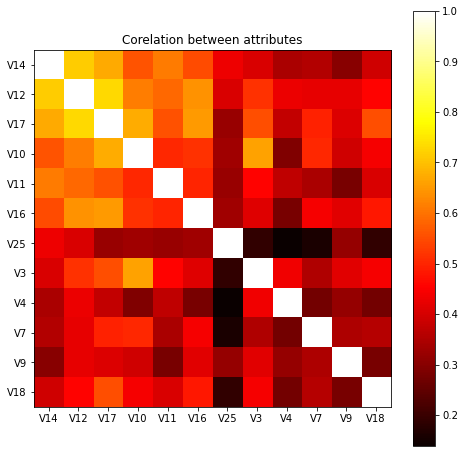

In [627]:
#get correlation table of attributes
fig = plt.figure(figsize=(8,8))
cor_array = np.asarray(df[attributes].corr().abs())
plt.imshow(cor_array,cmap='hot',interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=range(len(attributes)),labels=attributes)
plt.yticks(ticks=range(len(attributes)),labels=attributes)
plt.title("Corelation between attributes")
plt.show()

In the upper right corner of the above heatmap it appears that some features are highly correlated. I will find these and further eliminate the features which are less correlated with the target value 'Fraud'.

In [628]:
#find highly correlated features
cor_table = df2.corr()
cor_table[(cor_table>0.7) & (cor_table<1)].stack().index

MultiIndex([('V14', 'V12'),
            ('V12', 'V14'),
            ('V12', 'V17'),
            ('V17', 'V12')],
           )

In [629]:
#check pairs of features (V14, V12) and (V12, V17) against 'Fraud' target
highly_correlated_features = ['V12' , 'V14', 'V17', 'Fraud']
df[highly_correlated_features].corr().abs()


,V12,V14,V17,Fraud
V12,1.000000,0.716885,0.733692,0.697491
V14,0.716885,1.000000,0.671163,0.742423
V17,0.733692,0.671163,1.000000,0.642797
Fraud,0.697491,0.742423,0.642797,1.000000


From the above table, the attribute V14 is the most important feature among all V12, V14 and V17. Therefore I will inlcude V14 in my dataset for modelling and drop the other two.

In [630]:
attributes=attributes.delete([1,2])
attributes

Index(['V14', 'V10', 'V11', 'V16', 'V25', 'V3', 'V4', 'V7', 'V9', 'V18'], dtype='object')

Here I explore whether the dataset contains any missing values. As we see below, the attribute V1 contains missing values - NaN values. 

However, V1 correlation to the target value 'Fraud' does not meet the minimum threshold which I set as 0.3 therefore is not further selected for the analysis. If I want to include this attribute in my analysis in the future I will need to replace the Nan values with the mean or either drop these rows. Since these instances are only 4 out of total 9997, I would need to replace these NaN values with the mean. 

In [631]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    9997 non-null   int64  
 1   V1      9993 non-null   float64
 2   V2      9997 non-null   float64
 3   V3      9997 non-null   float64
 4   V4      9997 non-null   float64
 5   V5      9997 non-null   float64
 6   V6      9997 non-null   float64
 7   V7      9997 non-null   float64
 8   V8      9997 non-null   float64
 9   V9      9997 non-null   float64
 10  V10     9997 non-null   float64
 11  V11     9997 non-null   float64
 12  V12     9997 non-null   float64
 13  V13     9997 non-null   float64
 14  V14     9997 non-null   float64
 15  V15     9997 non-null   float64
 16  V16     9997 non-null   float64
 17  V17     9997 non-null   float64
 18  V18     9997 non-null   float64
 19  V19     9997 non-null   float64
 20  V20     9997 non-null   float64
 21  V21     9997 non-null   float64
 22  

From the table below is obvious that the attributes are all very similar between them with similar means and standard deviation. Nevertheless, as I intend to use the classification kNN technique which is based on the Eucledian distance metric to estimate the nearest neighbours, the better approach to this is to standardise the features by removing the mean and scaling to unit variance.

In their work Introduction to Data Mining,  Tan et al clarify that "the goal of standardization or normalization is to make an entire set of valueshave a particular property" (Tan et al,2019 p.90). 

In [632]:
df2.describe()

,V14,V12,V17,V10,V11,V16,V25,V3,V4,V7,V9,V18
count,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000
mean,-0.329504,-0.312208,-0.282324,-0.199111,0.049287,-0.313560,-1.295028,-0.578172,0.385147,-0.147936,-0.206448,-0.065295
std,2.035587,1.939997,2.259509,1.983392,1.418662,1.571963,0.567101,2.781635,2.118301,2.874139,1.346458,1.238329
min,-19.214325,-18.683715,-25.162799,-24.588262,-3.684586,-14.129855,-10.295397,-31.103685,-5.266509,-43.557242,-13.434066,-9.498746
25%,-0.647428,-0.544243,-0.560746,-0.688936,-0.861593,-0.846624,-1.479027,-1.183218,-0.864526,-0.527063,-0.860413,-0.580695
50%,-0.019493,0.067554,-0.014330,-0.096856,-0.049577,-0.162684,-1.207582,0.043928,-0.136180,0.182848,-0.126675,0.052701
75%,0.520247,0.577834,0.482012,0.653108,0.686376,0.510768,-1.057593,0.856952,1.130185,0.817359,0.553565,0.644404
max,7.754599,4.472921,6.739384,23.745136,12.018913,7.059132,2.208209,9.382558,16.875344,31.527244,15.594995,5.041069


## Model 1 development 

Since the problem at hand is a classification problem, I intend to use KNN machine learning algorith as my first technique. The reasons are:
* KNN is a good machine learning model that works well with numerical data
* This model performs good on relatively small datasets which make it good selection for this problem
* KNN is easy to interpret and is based on the simple Eucledian distance. The features have been standardise and ready to apply KNN algorithm. 
* KNN performs well with small numbers of features (attributes) therefore is a good candidate model for this problem, especially after I have removed the non relevant features.
* KNN can be an extremely fast algorithm. As Tan et al explain (2019) nearest neighbours algorithms can be extremely fast since they require no training on the data.   

<br><br><br>

### Schematic figure of the process 

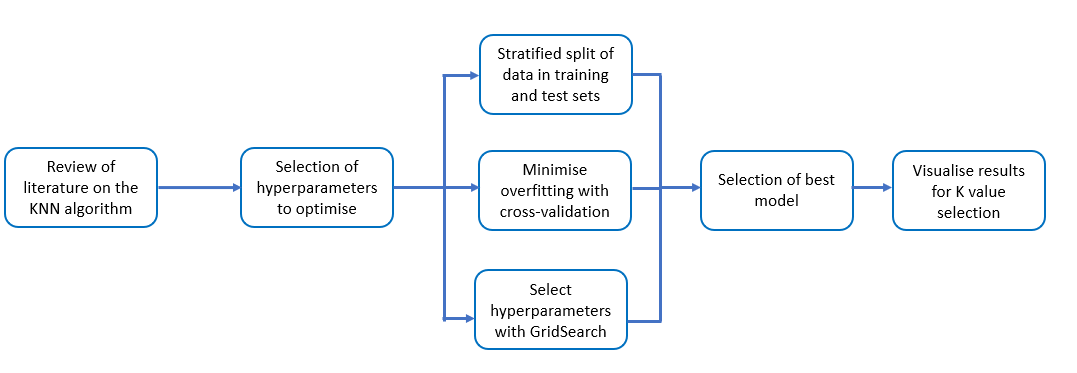

First I will standardise my dataset as explained above.

In [633]:
scaler = StandardScaler()
df2_scaled  = scaler.fit_transform(df2)
processed_data = pd.DataFrame(df2_scaled)
processed_data.columns = df2.columns
processed_data.head()

,V14,V12,V17,V10,V11,V16,V25,V3,V4,V7,V9,V18
0,-4.819831,-6.594528,-7.623404,-5.547487,6.541360,-6.225083,-6.148380,-4.274173,4.373140,-7.576516,-3.139293,-6.457342
1,1.853084,-0.597706,0.752652,1.000877,0.930005,-0.835030,-3.953089,0.186376,0.320857,-3.211588,1.632927,-1.092351
2,-2.722660,-0.049148,2.577321,-1.066730,1.532276,1.268180,-1.982847,-1.341789,0.973911,-0.920128,-0.052181,2.643156
3,-3.450424,-6.867884,-7.664230,-8.120047,3.894244,-5.353182,-1.538571,-6.888818,4.758164,-8.083718,-5.648120,-5.968553
4,-2.152309,-2.017639,-2.588994,-2.002484,2.617400,-2.815426,-1.384127,-1.572851,1.868138,-1.830071,-0.858406,-1.906354


The major hyperparameter to be controlled in KNN algorithm is the number K of the neighrest neighbours we want to achieve to make a valid conclusion on the label of the instance. 
A way to select the optimum K is by the elbow method (1). 
Another method to select the optimum value of K is by varying the K value and observe where the testing error starts to fork from the training error (1). Also by applying cross validation on the training set will help to identify the value of K that gives the best score. Specifically since the data is imbalanced, a better approach is to use stratified corss-validation.

<p>

References:

(1) Altahhan, A. 2021. Clustering and Classification algorithms. Lecture notes distributed in OCOM5101M Data Science. 24 May, University of Leeds.



### Optimising hyper parameters 

In this section I will perform GridSearch with stratified cross-validation to find out about the best hyperparameters (based on my selected ranges). This method will help me to prevent overfitting on the training data by training on a series of multiple splits, holding out a validation set for testing. 

In [634]:
#set training dataset
X = processed_data.values
y = df.Fraud

#perform stratified split on the data to preserve the class proportionality
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

# create instance of KNN 
knn = KNeighborsClassifier()

# perform stratified cross validation with sklearn
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#perform gridsearch to identify the optimum 
model_parameters = {'n_neighbors':list(range(1,51,5))}
test_model_KNN = GridSearchCV(estimator=knn, param_grid=model_parameters, scoring = 'f1', cv=skfold, n_jobs=-1) #use f1 score as a metric for imbalanced dataset
test_model_KNN.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46]},
             scoring='f1')

Let's look at the best estimator and the best score that has achieved.

In [635]:
print(test_model_KNN.best_estimator_)
print(test_model_KNN.best_score_)

KNeighborsClassifier(n_neighbors=1)
0.9780462870462869


## Performance metrics for training

Using the above best estimator I will train this using the training dataset to retrieve the performance metrics for training.

In [636]:
#use best estimator for predicting the labels on the training set
y_pred_train = test_model_KNN.best_estimator_.predict(X_train)
#print classification report
print(classification_report(y_train, y_pred_train))
print(f'\nThe F1 score for the KNN classifier on training dataset is: {f1_score(y_train, y_pred_train):.3}\n')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7603
           1       1.00      1.00      1.00       394

    accuracy                           1.00      7997
   macro avg       1.00      1.00      1.00      7997
weighted avg       1.00      1.00      1.00      7997


The F1 score for the KNN classifier on training dataset is: 1.0



It is clear that the best estimator KNN model trained on the training dataset performs exceptionally well with a macro F1 score=1. 

The weighted F1 score favours the label in the dataset which appears more frequently by setting the weight of this equal to the proportion of the label with respect to the data size. In this application, since the fraudulent instances account only for 5% of the dataset, using the weighted F1 score will tend to give higher score since the non-fraudulent instances account for apprx. 95%. Therefore the model will predict the most frequent label most of the time (depending on model selection and parameters) and it will not give a good indication of the performance on the unbalanced dataset.
<p>
From the graph below of the scoring against the K values it can be seen that the highest performance is achieved by the model when the value K is equal to 1.  

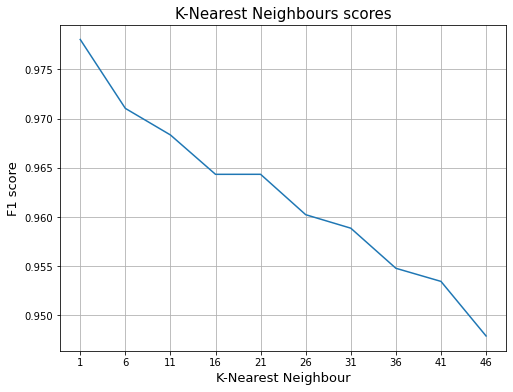

In [637]:
#plot the scoring graph 
scores = test_model_KNN.cv_results_['mean_test_score']
k_values = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46]
fig = plt.figure(figsize=(8,6))
plt.plot(k_values, scores)
plt.xticks(k_values, labels=k_values)
plt.ylabel('F1 score', fontdict={'fontsize':13})
plt.xlabel('K-Nearest Neighbour', fontdict={'fontsize':13})
plt.title('K-Nearest Neighbours scores', fontdict={'fontsize':15})
plt.grid()

## Model 2 Devlopment

Since the problem at hand is a classification problem, I intend to use RandomForest machine learning algorith as my second technique. The reasons for using RandomForest model are:
* As explained in (1), ensemble machine learning models take advantage of their agregated decisions which are based on samping methods of the input dataset by diversifying the properties of each sub-model within the ensemble and exposing various dynamics for each data split. This will enable to take a more sophisticated approach towards classification with the method of  'model voting'.
* Due to the random sampling of the data attributes for each sub-model of the ensemble, this method promotes diverisity among the predictors (Tan et al,2019). 
* Random Forest classifier, due to its underlying functionality has low bias and reduced variance. As a result this makes the Random Forest classification model robust to overfitting.
* With Random Forest classifier, standardisation or normalisation of data is not required since the model operates on a rule-based approach. This makes the model robust to datasets which exhibit high variety of the scales among all attributes.  


References:

(1) Altahhan, A. 2021. Clustering and Classification algorithms. Lecture notes distributed in OCOM5101M Data Science. 24 May, University of Leeds.
<br><br><br>

### Schematic figure of the process 

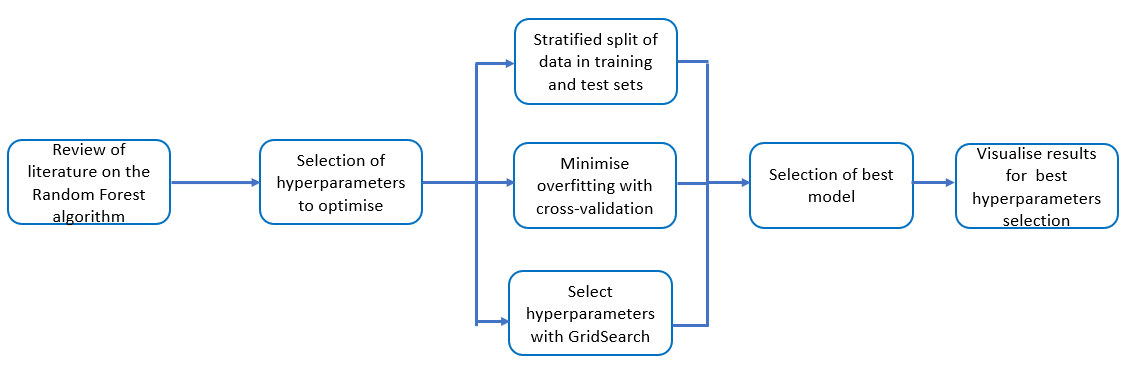

The ensemble model Random Forest, is a robust model when it comes to overfitting. It enables to adjust its parameters so that the trees do not overgrow and prevent overfitting. I have selected the following hyperparameters to tune and compare with the method of GridSearch:
* _Number of estimators_: by introducing a variety of estimators in the ensemble model, it promotes the decorrelation of the sub-models to enhance the aggregate decision from each participant tree. Setting parameters such as bootstrap to 'True', will further infuse diversity among the trees and help to improve the results.
* _Maximum depth_: If a tree is allowed to fully grow, then it will make splits at each node until the impurity reaches 0. However, this is not a good approach because if the model is used on unseen data, the same splits performed while training the model may not follow exactly the same route with the new data. Therefore the model will not be able to generalise well on the new data.
* _Maximum leaf nodes_: Limiting the number of leaf nodes is a pre-pruning technique to prevent the tree from fully growing which helps to avoid overfitting of the model. 

References:

Scikit-learn developers 2020. Random Forest classifier website. [Online]. [Accessed 25 June 2021]. Available from: https://scikit-learn.org 



### Optimising hyper parameters


In this section I will perform GridSearch with stratified cross-validation to find out about the best hyperparameters (based on my selected ranges). This method will help me to prevent overfitting on the training data by training on a series of multiple splits, holding out a validation set for testing. I make use of the stratifired split X_train and y_train sets which have been computed in the previous technique. 

In [638]:
# create instance of RandomForest 
RF = RandomForestClassifier()

# perform stratified cross validation with sklearn
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#perform gridsearch to identify the optimum 
model_parameters = {'n_estimators':list(range(1,100,20)), 
                    'max_depth': list(range(2,20,2)),
                    'max_leaf_nodes': list(range(2,10,2)) }
test_model_RF = GridSearchCV(estimator=RF, param_grid=model_parameters, scoring = 'f1', cv=skfold, n_jobs=-1) #use f1 score as a metric for imbalanced dataset
test_model_RF.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_leaf_nodes': [2, 4, 6, 8],
                         'n_estimators': [1, 21, 41, 61, 81]},
             scoring='f1')

Let's view the best hyperpatameters and best scores that the estimator has computed.

In [639]:
print(test_model_RF.best_params_)
print(test_model_RF.best_score_)

{'max_depth': 8, 'max_leaf_nodes': 6, 'n_estimators': 41}
0.9961367746177873


In [640]:
#create a dataframe from the model hyperparameters and scores
RF_grid_results = pd.DataFrame(test_model_RF.cv_results_['params'])
RF_grid_results['F1_score'] = test_model_RF.cv_results_['mean_test_score']
RF_grid_results['Combined_parameters'] = RF_grid_results.apply(
                                        lambda x:'%s, %s, %s' % (int(x['max_depth']),int(x['max_leaf_nodes']),int(x['n_estimators']))
                                                    ,axis=1)
RF_grid_results.head()

,max_depth,max_leaf_nodes,n_estimators,F1_score,Combined_parameters
0,2,2,1,0.825649,"2, 2, 1"
1,2,2,21,0.889475,"2, 2, 21"
2,2,2,41,0.886481,"2, 2, 41"
3,2,2,61,0.882744,"2, 2, 61"
4,2,2,81,0.878815,"2, 2, 81"


### Performance metrics for training

Using the above best estimator I will train this using the training dataset to retrieve the performance metrics for training.

In [641]:
#use best estimator for predicting the labels on the training set
y_pred_train = test_model_RF.best_estimator_.predict(X_train)
#print classification report
print(classification_report(y_train, y_pred_train))
print(f'\nThe F1 score for the Random Forest classifier on training dataset is: {f1_score(y_train, y_pred_train):.3}\n')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7603
           1       1.00      0.99      1.00       394

    accuracy                           1.00      7997
   macro avg       1.00      1.00      1.00      7997
weighted avg       1.00      1.00      1.00      7997


The F1 score for the Random Forest classifier on training dataset is: 0.996



Below I plot the F1_score for each of the hyperparameters combination as it is shown in the dataframe above. The column 'Combined_parameters' in the dataframe includes entries of three integers which represent the ( _max_depth, max_leaf_nodes, n_estimators_ ). 
<p>The same for the graph below, each value of the X-axis represents this tuple of hyperparameters. I also highlighted in red the highest score which makes it easier to recognise from the graph.

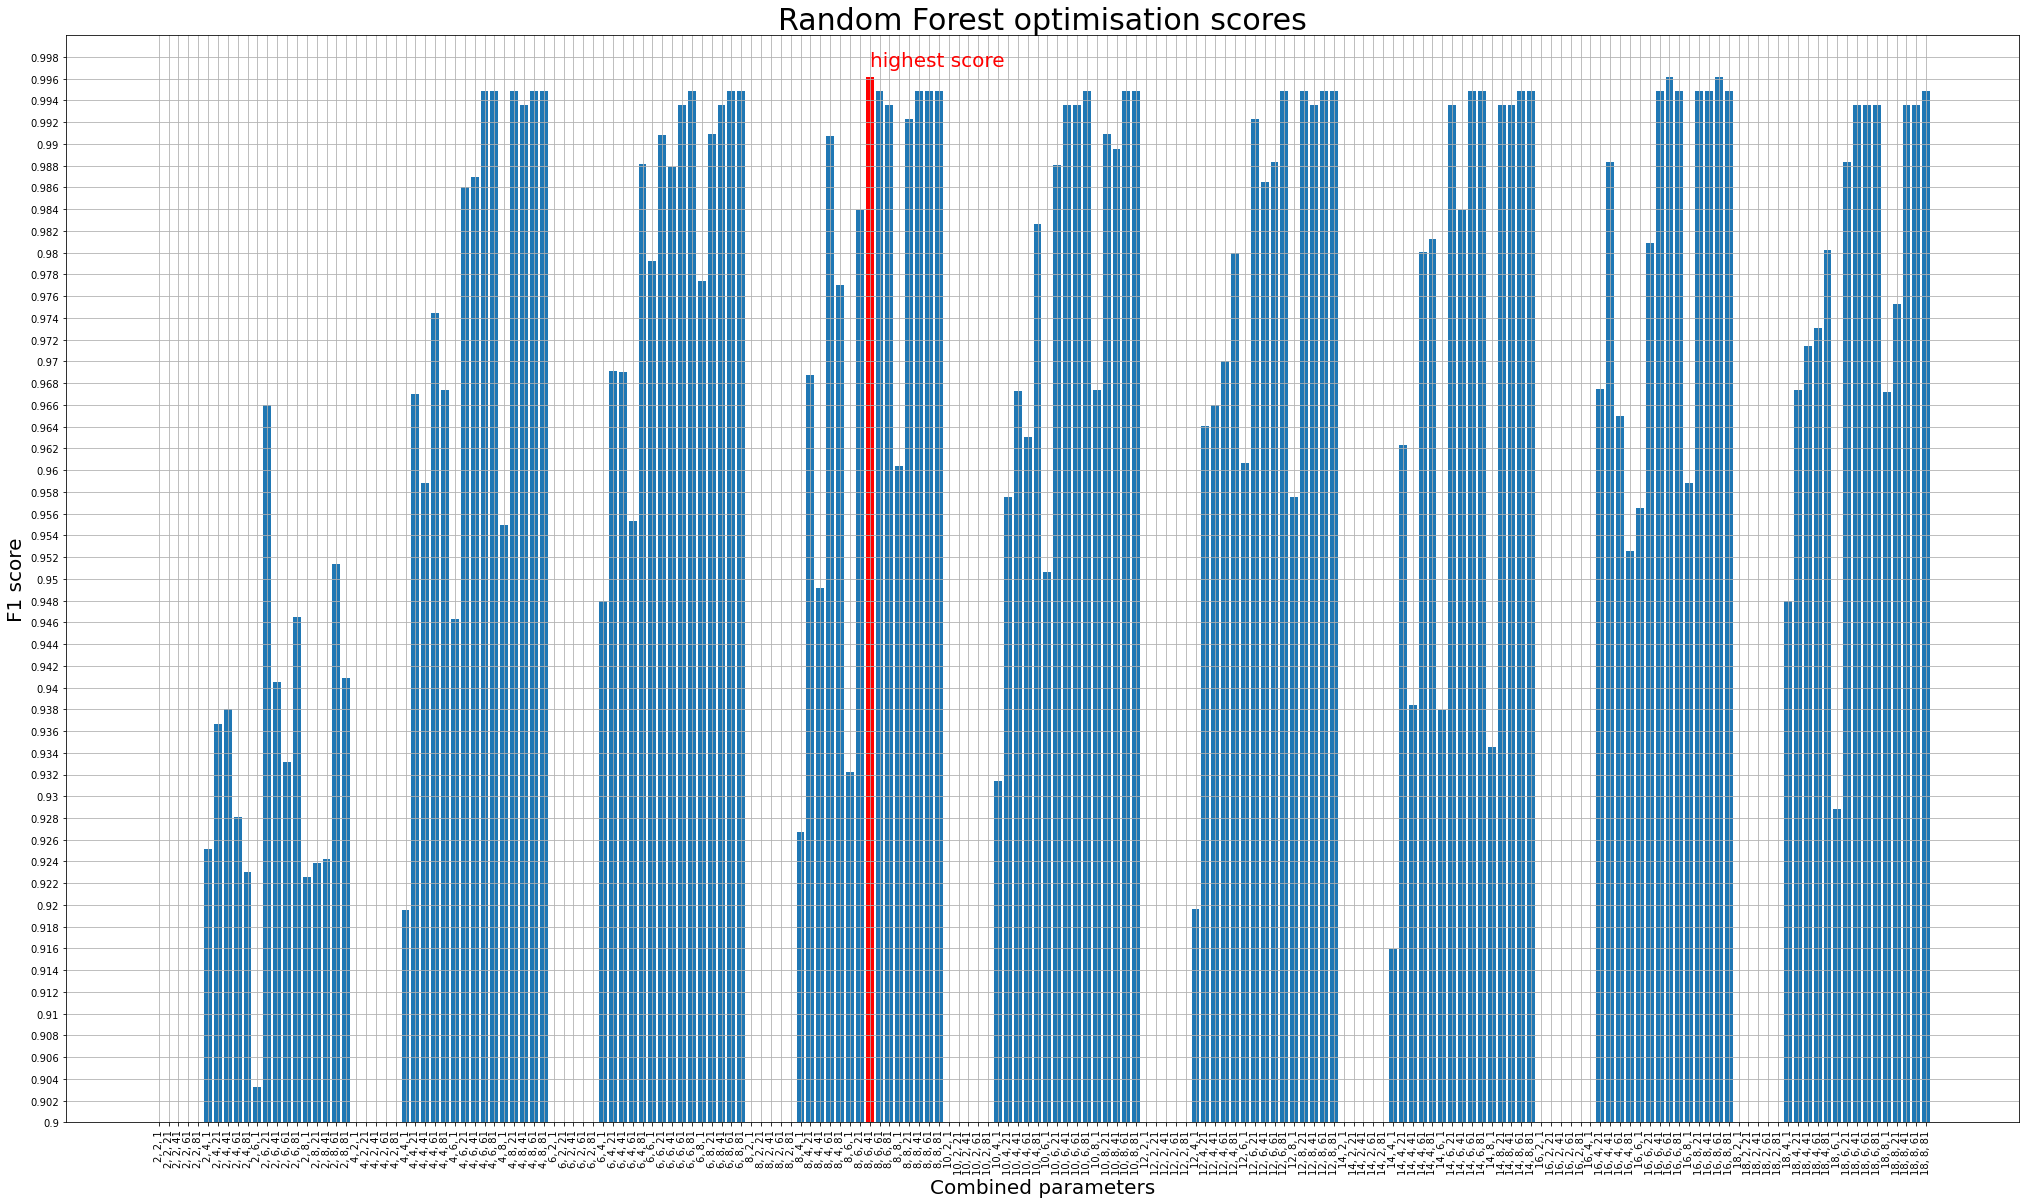

In [642]:
#plot the scoring graph 
scores = RF_grid_results.F1_score
combined_params = RF_grid_results.Combined_parameters
fig = plt.figure(figsize=(35,20))
plt.bar(combined_params, scores)
plt.xticks(combined_params, labels=combined_params,rotation=90)
plt.yticks(np.arange(0.9,1,0.002).round(3), labels=np.arange(0.9,1,0.002).round(3))
plt.ylabel('F1 score', fontdict={'fontsize':20})
plt.xlabel('Combined parameters', fontdict={'fontsize':20})
plt.ylim(0.9, 1)
#find the maximum score index
max_idx = RF_grid_results.F1_score.idxmax()
x = RF_grid_results.Combined_parameters[max_idx]
y = RF_grid_results.F1_score[max_idx]
#highlight in red the maximum socre on graph
plt.bar(x, y, color='red')
plt.annotate('highest score', xy=(x,y+0.001), fontsize=20, color='red')
plt.title('Random Forest optimisation scores', fontdict={'fontsize':30})
plt.grid()


## Comparison of metrics performance for testing 



### Use of cross validation for both techniques to deal with over-fitting

I have demonstarted the use of cross validation in both techniques above, KNN and RandomForest classifiers, which help to minimise overfitting and reduce the model variance. Specifically I have applied sttatified cross-validation since the dataset is largely imbalanced: 95% of normal cases vs 5% of fraudulent cases.

The cross validation (using GridSearch) scores are averaged and give a more holistic understanding on the model behaviour for each split of the data. The data are shuffled multiple times to esnure that a diversity of samples is preserved to enhance decorrelated computations.  

Let's view the cross validation scores for each of the estimators.

In [643]:
print('The averaged cross-validation scores for each run for the KNN classifer are:\n')
print(test_model_KNN.cv_results_['mean_test_score'],'\n')

The averaged cross-validation scores for each run for the KNN classifer are:

[0.97804629 0.97104313 0.9683432  0.96434123 0.96434313 0.96023832
 0.958868   0.95479339 0.95346051 0.94791404] 



In [644]:
print('The averaged cross-validation scores for each run for the Random Forest classifer are:\n')
print(test_model_RF.cv_results_['mean_test_score'],'\n')

The averaged cross-validation scores for each run for the Random Forest classifer are:

[0.82564906 0.8894748  0.88648068 0.88274441 0.87881466 0.9251731
 0.93660891 0.93801558 0.92808435 0.92302443 0.90323558 0.96598947
 0.9405435  0.9331543  0.94647694 0.92261902 0.92383569 0.92419781
 0.95132281 0.94085926 0.87385894 0.88655363 0.88895903 0.89264824
 0.89081912 0.91954251 0.96700094 0.95882372 0.97442951 0.9674022
 0.94629483 0.9860069  0.98693888 0.99487095 0.99487095 0.954959
 0.99487095 0.99357267 0.99487095 0.99487095 0.81781616 0.88557711
 0.89167722 0.8874719  0.88687925 0.94799422 0.96908844 0.96903422
 0.9553005  0.98816685 0.97924236 0.99083807 0.98783632 0.99357267
 0.99487095 0.97740941 0.99087095 0.99357267 0.99487095 0.99487095
 0.78474807 0.87414156 0.88268806 0.89258517 0.89113227 0.92669769
 0.96877797 0.94918934 0.99073137 0.97699278 0.93220082 0.98390734
 0.99613677 0.99487095 0.99357267 0.96034923 0.99230727 0.99487095
 0.99487095 0.99483807 0.87586006 0.87439363 

### Comparison with appropriate metrics for testing

Here I will perform the evauation of the two classifiers using the stratified X_test & y_test dataset obtained previously. It is also important to calculate the confusion matrix to understand how the models perform in relation to the business demands; meaning mimimise the False Negatives and False Positives instances.
The best estimator from each model is used.

In [645]:
#Evaluation metrics for KNN model
#use best estimator for predicting the labels on the testing set
y_pred_KNN = test_model_KNN.best_estimator_.predict(X_test)
#print classification report
print(classification_report(y_test, y_pred_KNN))
print(f'\nThe fraudulent class F1 score for the KNN classifier on testing dataset is: {f1_score(y_test, y_pred_KNN):.3}\n')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1902
           1       0.99      0.94      0.96        98

    accuracy                           1.00      2000
   macro avg       0.99      0.97      0.98      2000
weighted avg       1.00      1.00      1.00      2000


The fraudulent class F1 score for the KNN classifier on testing dataset is: 0.963



In [646]:
#Evaluation metrics for RF model
#use best estimator for predicting the labels on the testing set
y_pred_RF = test_model_RF.best_estimator_.predict(X_test)
#print classification report
print(classification_report(y_test, y_pred_RF))
print(f'\nThe fraudulent class F1 score for the Random Forest classifier on testing dataset is: {f1_score(y_test, y_pred_RF):.3}\n')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1902
           1       0.99      0.97      0.98        98

    accuracy                           1.00      2000
   macro avg       0.99      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000


The fraudulent class F1 score for the Random Forest classifier on testing dataset is: 0.979



Based on the scoring using the test sets on both classifiers it is demonstrated that the Random Forest classifier outperforms the KNN classifier. How much better is Random Forest classifer doing in terms of meeting the business case criteria?

Remind that the business criteria are:
* Achieve a Recall of >90% (with respect to the fraudulent class-1) - **achieved for both models**
* Achieve a Precision of >70% (with respect to the fraudulent class-1) - **achieved for both models**
* Do not exceed >30 of False Positives instances - **?**
* Do not exceed >5 of False Negatives instances - **?**

Below I will compare the models with respect to the financial losses.

In [647]:
#function to plot the confusion matrix
def plot_confusion_matrix(ytrue, ypred, labels,title, normalise=False):
    """
    This function plots confusion matrix. 
    If Normalize='True' plot with normalised values.

    """
    cm = confusion_matrix(ytrue, ypred, labels=labels)
    plt.figure(figsize=(5,5))
    if normalise:
        cm = cm/ cm.sum(axis=1)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    #format and show values in the matrix 
    if normalise:
        type_format = '.2f'
    else:
        type_format = 'd'
    #set threshold for value visibility
    threshold = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], type_format), horizontalalignment="center",color="white" if cm[i, j] > threshold else "black")
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    
#function to retrieve FP,FN,TP,TN counts
def class_predictions(ytrue, ypred, labels):
    """
    Accepts the labels in [1,0] format. True label first.
    Returns TP, FP, TN, FN

    """    
    cm = confusion_matrix(ytrue, ypred, labels=labels)
    TP=FP=TN=FN = 0
    #get the TP 
    TP = cm[0,0]
    #get the TN
    TN = cm[1,1]
    #get the FN
    FN = cm[0,1]
    #get the FP
    FP = cm[1,0]
    return TP,FP,TN,FN
    

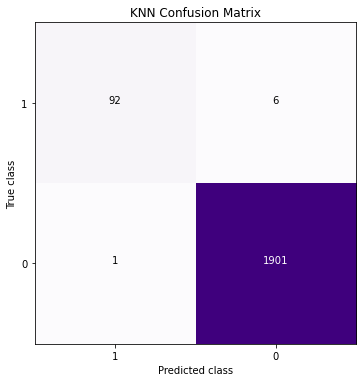

In [648]:
#plot confusion matrix for KNN classifier
plot_confusion_matrix(y_test, y_pred_KNN, labels=[1,0], title='KNN Confusion Matrix', normalise=False)
TP, FP, TN, FN = class_predictions(y_test, y_pred_KNN, labels=[1,0])


In [649]:
print(f'KNN classifier returns {FP} False Positives. At the cost of £1k for each FP the financial loss = £1k x {FP} = £{1*FP}k\n')
print(f'KNN classifier returns {FN} False Negatives. At the cost of £10k for each FP the financial loss = £10k x {FN} = £{10*FN}k\n')
print(f'The total financial loss for the KNN model is £{10*FN}k + £{1*FP}k = £{1*FP + 10*FN}k')

KNN classifier returns 1 False Positives. At the cost of £1k for each FP the financial loss = £1k x 1 = £1k

KNN classifier returns 6 False Negatives. At the cost of £10k for each FP the financial loss = £10k x 6 = £60k

The total financial loss for the KNN model is £60k + £1k = £61k


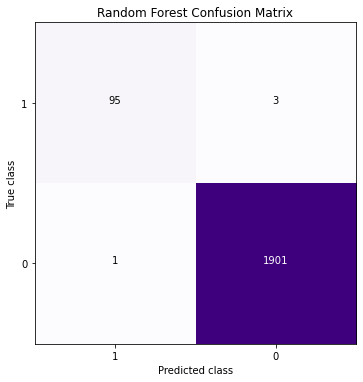

In [650]:
#plot confusion matrix for Random Forest classifier
plot_confusion_matrix(y_test, y_pred_RF, labels=[1,0], title='Random Forest Confusion Matrix', normalise=False)
TP, FP, TN, FN = class_predictions(y_test, y_pred_RF,labels=[1,0])


In [651]:
print(f'RF classifier returns {FP} False Positives. At the cost of £1k for each FP the financial loss = £1k x {FP} = £{1*FP}k\n')
print(f'RF classifier returns {FN} False Negatives. At the cost of £10k for each FP the financial loss = £10k x {FN} = £{10*FN}k\n')
print(f'The total financial loss for the RF model is £{10*FN}k + £{1*FP}k = £{1*FP + 10*FN}k\n')

RF classifier returns 1 False Positives. At the cost of £1k for each FP the financial loss = £1k x 1 = £1k

RF classifier returns 3 False Negatives. At the cost of £10k for each FP the financial loss = £10k x 3 = £30k

The total financial loss for the RF model is £30k + £1k = £31k



Its is obvious that Random Forest classifier will tend to be the better option for this application and achieve higher financial savings.

### Model selection  - comparison

The Area Under Curve score and the ROC curves are good method to compare different classification models. Particularly in this problem, since we care more about the False Negative predictions because they cost more money to the bank, we want to compare and identify whiuch model minimises best the False Negatives. For this reason we expect to see on the ROC curve a high True Positive rate which will push the ROC curve towards the uppper left corner of the graph.  

References:

Scikit-learn developers 2020. Receiver Operating Characteristic website. [Online]. [Accessed 25 June 2021]. Available from: https://scikit-learn.org 

In [652]:
#calculate KNN probabilities 
y_prob_test_KNN = test_model_KNN.best_estimator_.predict_proba(X_test)

In [653]:
#calculate RF probabilities 
y_prob_test_RF = test_model_RF.best_estimator_.predict_proba(X_test)

The KNN ROC Area Under Curve is 0.969
The Random Forest ROC Area Under Curve is 1.000


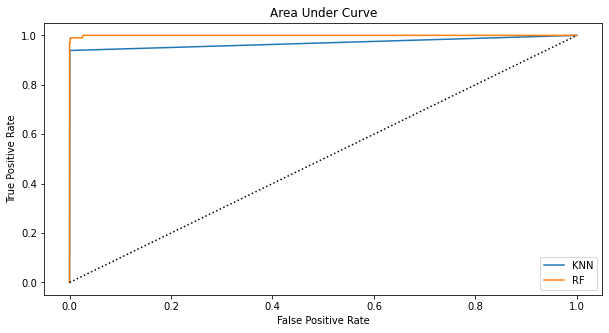

In [654]:
# calculate the Area Under Curve scores
KNN_auc_score = roc_auc_score(y_test,y_prob_test_KNN[:, 1])
RF_auc_score = roc_auc_score(y_test, y_prob_test_RF[:, 1])
# print the AUC scores
print(f'The KNN ROC Area Under Curve is {KNN_auc_score:.3f}')
print(f'The Random Forest ROC Area Under Curve is {RF_auc_score:.3f}')      
# calculate the ROC curves
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(y_test,y_prob_test_KNN[:, 1])
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_prob_test_RF[:, 1])
# plot the ROC curves for each model
plt.figure(figsize=(10,5))
plt.plot(fpr_KNN, tpr_KNN, label='KNN')
plt.plot(fpr_RF, tpr_RF, label='RF')
plt.plot([0, 1], [0, 1], color='k',linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Curve')
plt.legend()
plt.show()

From the ROC graph, both models perform really well for this problem. Especially the Random Forest classifier performs even better than the KNN classifier and this is also demonstarted by the calculated areas under curve, in which Random Forest classifier achieves a higher score. 

## Final recommendation of best model

* In this problem, both models KNN classifier and Random Forest classifier performed well on classifying the fraudulent credit card transactions.
* Even though both estimators achieved very high performance metrics, close to 100%, it has been demonstarted that the Random Forest model outperforms the KNN model. As it was explained above, this in effect, demonstrates how powerful are ensemble methods.
* Both models have performed well with respect to avoing overfitting. This is understood by comparing the performance scores of predictions using the training and testing datasets separately. Both training and testing performance metrics are very close, which is the indicator that the models do not overfit. Refer to the classification scores above. 
* The use of stratified sampling and cross validation with GridSearch method has helped to achieve model optimisation. 
* KNN classifier can be extremely fast, once all distances between the points (samples) have been calculated. However, when a new instance is given to be classified, the algorithm will need to re-estimate all the distances between the samples. During model optimisation the model concludes to the best parameters very fast as the only major parameter to be optimised is the K-Neighbours.
* Random Forest is also a fast algorithm to train but once the best estimator is selected, future instances are faster to calculate than KNN classifier since there is no need to re-train the model. During optimisation process, Random Forest classifier takes significantly more time than the KNN classifier to conclude on the best estimator due to the higher number of model hyperparameters and the combinations that grid search needs to compare.  

### Review results from a business perspective


As it has been demonstrated above, from a business point of view both models are able to achieve the desired Recall (>90%) and Precission (>70%) as specified by the client (the bank).

The most important comparison from the financial point of view is the running costs of the models based on their capabilities to minimise the False Positives and False Negatives instances. And as it has been shown, the Random Forest classifier is able to achieve substantial financial savings for the bank. 

Based on the overall performance metrics and the financial savings, the recommendatioin to be put forward to the bank, is to deploy the Random Forest classifier. 

## Conclusion

* The project has succesfully proven and concluded that the Random Forest classifier outperforms the KNN classifier and is able to meet the financial expenditures set by the bank. Therefore the recommended model to be deployed is Random Forest Classifier.
* The project succeeded in setting up appropriately the machine learning models to achieve very high performance scores to meet the business requirements.

### Future work

A list of future work I would recommend for further development is:

* Develop a logistic regression model and perform classification with the model. The logistic regression model is ideal to deal with this bulk of data and numerical features. The logistic regresssion model also provides the benefit of using the weights from each feature and perform feature engineering to narrow down the dataset only to the most important features, ie. to the features highly correlated to the target label.
* Perform PCA on the data for dimensionality reduction and draw the explained variance graph. This is a mathematically more sophisticated method to obtaon the attributes which carry the most of information (explained variance) to be used by the model.
* I also recommend to test the above trained machine learning algorithms on larger dataset which will enable for better model optimisation and help with achieving good generalisation. 
* Perform model optimisation including more parameters and consider a higher combination of hyperparameters.